# Client elegibility prediction using logistic regression



## Summary

This document showcasses the workflow of creating a real world sensible data set, that has client information that will be related with the fact of whether or not they are apt to receive a new line of credit. 

# Contents:

* Data set is born
* Use of bank criteria to create the training response variable
* statistical assessment of variables distributions, looking for multicollinearity
* Training of the model using cross validation
* Determination of model metrics and interpretation
* Conclusion

## Data Set is Born

For the sake of this demonstration, the following variables will be selected to describe the group of clients:


1. **Years_as_Client**: Number of years the client has been with the bank.

2. **Credit_Score**: Client's credit score (ranging from 300 to 850).

3. **Annual_Income**: Client's annual income in USD.

4. **Loan_Amount**: Total loan amount the client has borrowed.

5. **Loan_Duration_Years**: Duration of the client's loan in years.

6. **Missed_Payments**: Number of missed payments by the client.

7. **Credit_Eligibility**: Binary variable indicating if the client is eligible for credit (1 = eligible, 0 = not eligible). This variable doesn't have sense yet, it will be random number generated for now, but later, in the step `Use of bank criteria to create the training response variable` it will be fixed.


Now we will use pandas for handling the data frame, and numpy to generate random numbers:

In [1]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Number of clients
num_clients = 600

The variable years as a client can be normally distributed and generated by the `np.random.normal` function, having a central value of 10 years. 

In [2]:
# 1. Years as a Client (Normally distributed, mean=10 years, std=5 years)
years_as_client = np.random.normal(loc=10, scale=5, size=num_clients)
years_as_client = np.clip(years_as_client, 1, None)  # Ensure no negative values

Now, thanks to the [U.S. census bureau](https://www.census.gov/library/visualizations/2015/demo/distribution-of-household-income--2014.html), we know that the the distribution of income in the U.S. is right skewed, and a chi square distribution can be used to simulate both `annual income` and `credit score`.


count variables like `num_products` and `missed_payments`, as well as `loan duration in years` can be distributed normally. 

Here, we purposely will correlate `num_products` and `missed_payments`, to illustrate how to detect multicollinearity in the data set using python.

The following code will generate these variables according to what we have just discussed:


In [3]:
# 2. Credit Score (Chi-square distribution with k=3, scaled to 300-850 range)
credit_score_raw = np.random.chisquare(df=3, size=num_clients)

credit_score = np.interp(credit_score_raw, (credit_score_raw.min(), credit_score_raw.max()), (300, 850))

# 3. Number of Products (Normally distributed, mean=3 products, std=1.5, clipped between 1 and 5)
num_products = np.random.normal(loc=3, scale=1.5, size=num_clients)
num_products = np.clip(num_products, 1, 5)  # Number of products between 1 and 5

# 4. Missed Payments (Correlated with Number of Products)
# We'll generate missed payments to be positively correlated with the number of products
missed_payments = num_products + np.random.normal(loc=0, scale=0.5, size=num_clients)
missed_payments = np.clip(missed_payments, 0, 5)  # Missed payments between 0 and 5

# 5. Annual Income (Chi-square distribution, concentrated around $60,000 with scaling)
annual_income_raw = np.random.chisquare(df=2, size=num_clients)
annual_income = np.interp(annual_income_raw, (annual_income_raw.min(), annual_income_raw.max()), (30000, 150000))

# 6. Loan Amount (Log-normal distribution, reflecting right-skewness of loan amounts)
loan_amount = np.random.lognormal(mean=10, sigma=0.9, size=num_clients)
loan_amount = np.clip(loan_amount, 1000, 100000)  # Cap loan amounts between $1,000 and $100,000

# 7. Loan Duration in Years (Normally distributed, mean=10 years, std=5 years)
loan_duration_years = np.random.normal(loc=10, scale=5, size=num_clients)
loan_duration_years = np.clip(loan_duration_years, 1, 20)  # Loan duration between 1 and 20 years

# 8. Credit Eligibility (Binary outcome, 0 or 1)

credit_eligibility = np.random.randint(0, 2, num_clients)


Once the variables have been created, we can arrange them using a dictionary that can be converted into a pandas data frame using the `pd.DataFrame()` function.

In [4]:
# Create the dataset
data = {
    'Client_ID': range(1, num_clients + 1),
    'Years_as_Client': years_as_client,
    'Credit_Score': credit_score,
    'Num_Products': num_products,
    'Annual_Income': annual_income,
    'Loan_Amount': loan_amount,
    'Loan_Duration_Years': loan_duration_years,
    'Missed_Payments': missed_payments,
    'Credit_Eligibility': credit_eligibility
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Round the numerical values for better readability
df = df.round({
    'Years_as_Client': 1,
    'Credit_Score': 0,
    'Num_Products': 0,
    'Annual_Income': 0,
    'Loan_Amount': 0,
    'Loan_Duration_Years': 1,
    'Missed_Payments': 0
})

Now let's explore the structure of the data.set:


In [5]:
# Show first few rows of the dataset
print(df.head())

   Client_ID  Years_as_Client  Credit_Score  Num_Products  Annual_Income  \
0          1             12.5         476.0           4.0        48794.0   
1          2              9.3         334.0           1.0        77529.0   
2          3             13.2         434.0           3.0        44035.0   
3          4             17.6         669.0           5.0        43693.0   
4          5              8.8         308.0           1.0        31014.0   

   Loan_Amount  Loan_Duration_Years  Missed_Payments  Credit_Eligibility  
0       7801.0                  6.3              4.0                   1  
1       4824.0                 19.5              1.0                   0  
2       4383.0                 10.2              3.0                   0  
3       6504.0                 13.8              5.0                   1  
4      11636.0                  7.0              2.0                   1  


That's great! Just what we needed done in just a few steps. Isn't that wonderful?
 
Just a little thing before continuing, we can check how correlated `num_products` and `missed_payments` are using the `corr()` function from pandas:

In [6]:
# Check correlation between Num_Products and Missed_Payments
correlation = df[['Num_Products', 'Missed_Payments']].corr()
print("\nCorrelation between 'Num_Products' and 'Missed_Payments':")
print(correlation)


Correlation between 'Num_Products' and 'Missed_Payments':
                 Num_Products  Missed_Payments
Num_Products         1.000000         0.891501
Missed_Payments      0.891501         1.000000


strongly correlated. That's a little bit too exagerated, but this can happen and it helps to illustrate how to detect multicollinearity in the data set.


## Use of bank criteria to create the training response variable



Before saving the data set, we can address the problem of the response variable, how can we train the model if we don't have a response variable, that is sensible to real world economic criteria?

In [7]:
# Define the conditions based on which a customer is considered eligible (1) or not (0)
df['Credit_Eligibility'] = np.where(
    (df['Credit_Score'] >= 500) &               # Credit Score of 500 or more
    (df['Missed_Payments'] <= 2) &              # No more than 2 missed payments
    (df['Loan_Amount'] / df['Annual_Income'] < 0.4) &  # Loan amount is less than 40% of annual income
    (df['Annual_Income'] >= 40000),             # Minimum income threshold of $40,000
    1,  # Eligible for credit
    0   # Not eligible for credit
)

# Display the first few rows of the updated DataFrame
print(df[['Credit_Score', 'Missed_Payments', 'Loan_Amount', 'Annual_Income', 'Credit_Eligibility']].head())

   Credit_Score  Missed_Payments  Loan_Amount  Annual_Income  \
0         476.0              4.0       7801.0        48794.0   
1         334.0              1.0       4824.0        77529.0   
2         434.0              3.0       4383.0        44035.0   
3         669.0              5.0       6504.0        43693.0   
4         308.0              2.0      11636.0        31014.0   

   Credit_Eligibility  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  


Now that we have a logical response variable, we can save the data frame, and pretend we got it from a relevant, real world source (wink wink `;)`):

In [8]:
# Save the dataset to a CSV file
df.to_csv('credit_data.csv', index=False) 

## Statistical assessment of variables distributions, looking for multicollinearity

For this assessment we will use seaborn and matplotlib to plot the distributions of the variables, and the correlation matrix to detect multicollinearity.

Although I must admit I'm more of a visual learner, I will not deny the power of the `describe()` function from pandas, that can give us a quick overview of the data set:

In [9]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('credit_data.csv')

# Set the style for seaborn plots
sns.set(style='whitegrid')

# -----------------------------------------
# 1. Summary Statistics
# -----------------------------------------
print("\nSummary Statistics:\n")
print(df.describe())


Summary Statistics:

        Client_ID  Years_as_Client  Credit_Score  Num_Products  Annual_Income  \
count  600.000000       600.000000    600.000000    600.000000     600.000000   
mean   300.500000         9.984167    425.233333      3.013333   48816.480000   
std    173.349358         4.750956     98.666428      1.268531   18721.476714   
min      1.000000         1.000000    300.000000      1.000000   30000.000000   
25%    150.750000         6.500000    352.000000      2.000000   35657.250000   
50%    300.500000        10.050000    399.000000      3.000000   42883.500000   
75%    450.250000        13.100000    469.000000      4.000000   55685.750000   
max    600.000000        29.300000    850.000000      5.000000  150000.000000   

        Loan_Amount  Loan_Duration_Years  Missed_Payments  Credit_Eligibility  
count     600.00000           600.000000       600.000000          600.000000  
mean    30162.05000             9.719333         2.986667            0.020000  
std     

This output table from the `describe()` function alow us to have a mental idea of the range in which variables are, but *not gonna lie*, I prefer the visual representation of the data set, so let's plot the distributions of the variables using seaborn and matplotlib:

It's always useful to check for missing values first:

In [10]:
# -----------------------------------------
# 2. Check for missing values
# -----------------------------------------
print("\nMissing Values:\n")
print(df.isnull().sum())


Missing Values:

Client_ID              0
Years_as_Client        0
Credit_Score           0
Num_Products           0
Annual_Income          0
Loan_Amount            0
Loan_Duration_Years    0
Missed_Payments        0
Credit_Eligibility     0
dtype: int64


Thankfully we don't have any missing values, but it is worth to mention if that were the case, we could first assess how much percent of missing data there is, and then decide whether to drop the rows with missing values, or to impute them using the mean, median, or mode of the variable. 

Assessment of the distribution for non-normal variables like `annual_income` and `credit_score` can give fruits like the chance to use the distribution function to interpolate values and impute them.

First we can plot the distribution of the variables using seaborn's function histplot:

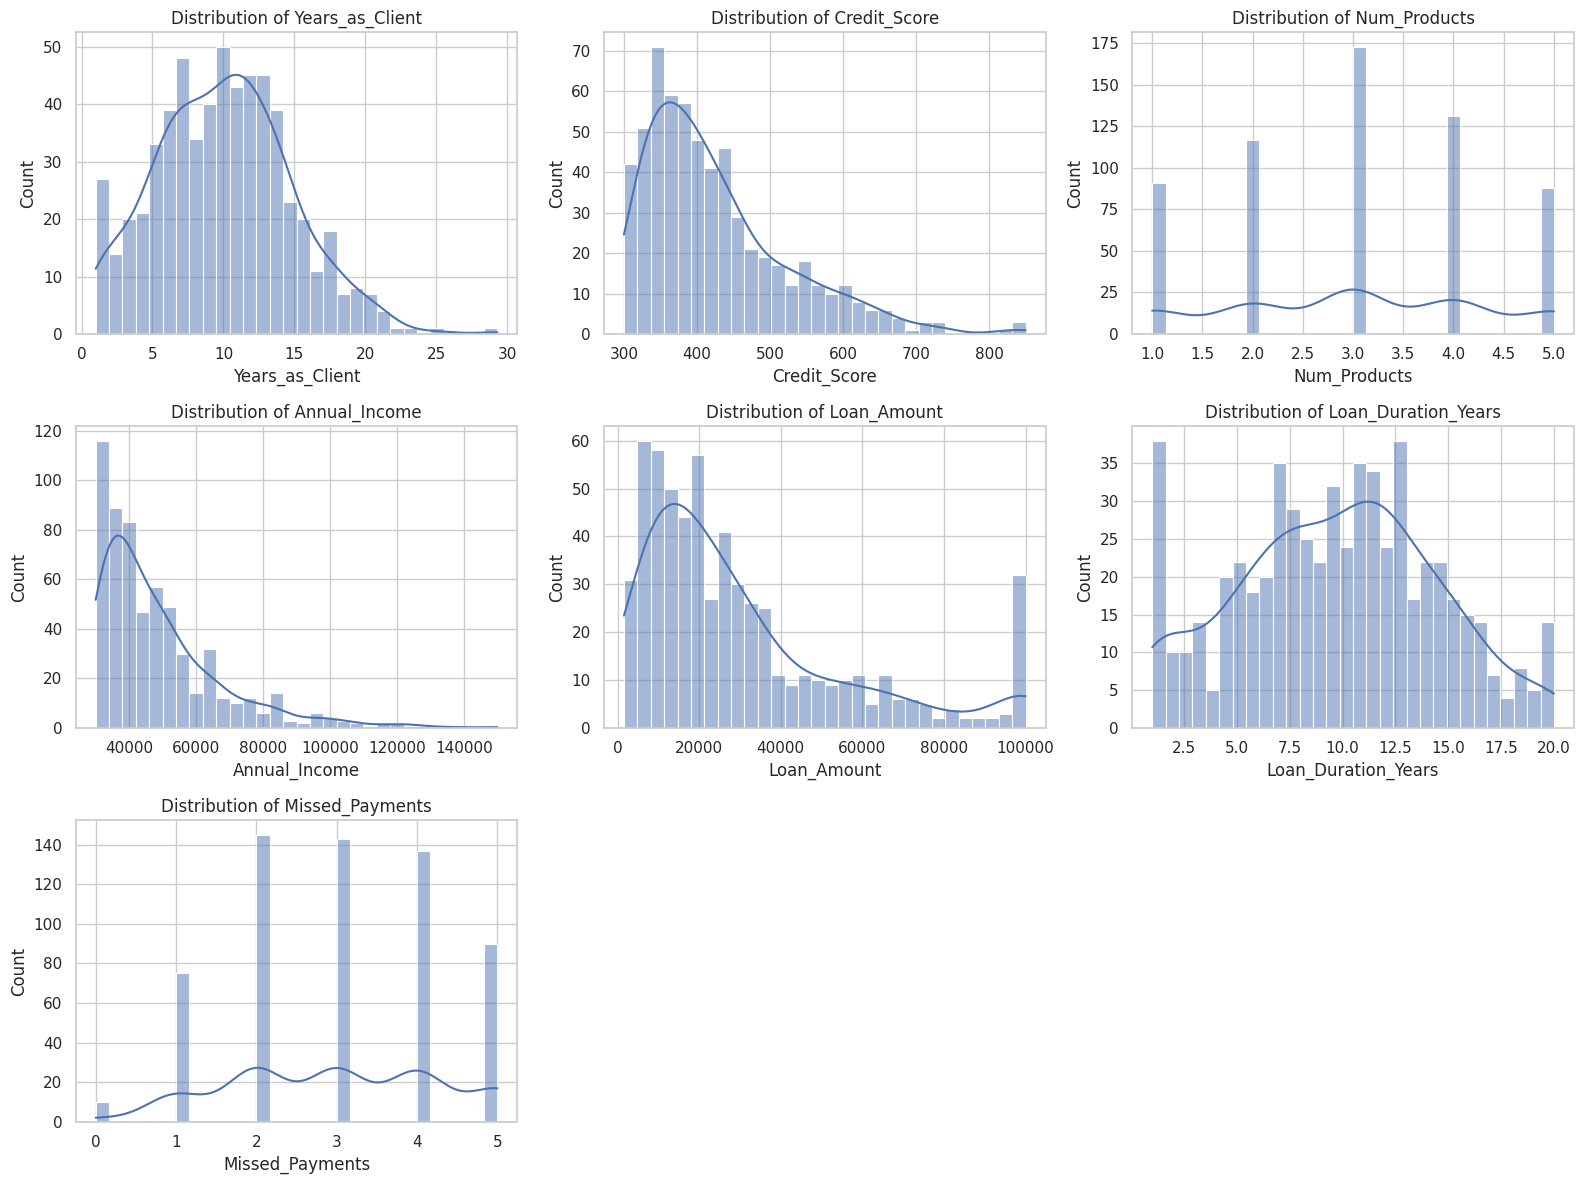

In [11]:

# List of numeric columns to visualize (excluding Client_ID)
numeric_columns = ['Years_as_Client', 'Credit_Score', 'Num_Products', 'Annual_Income', 'Loan_Amount', 
                   'Loan_Duration_Years', 'Missed_Payments']

# Plot histograms for each numeric variable
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

For this specific example, we get just what we asked for. For more real life scenarios keep posted, There will be a new notebook coming soon with a more complex, real life dataset.

Now let's complete the evaulation of these variables using boxplots to spot outliers:

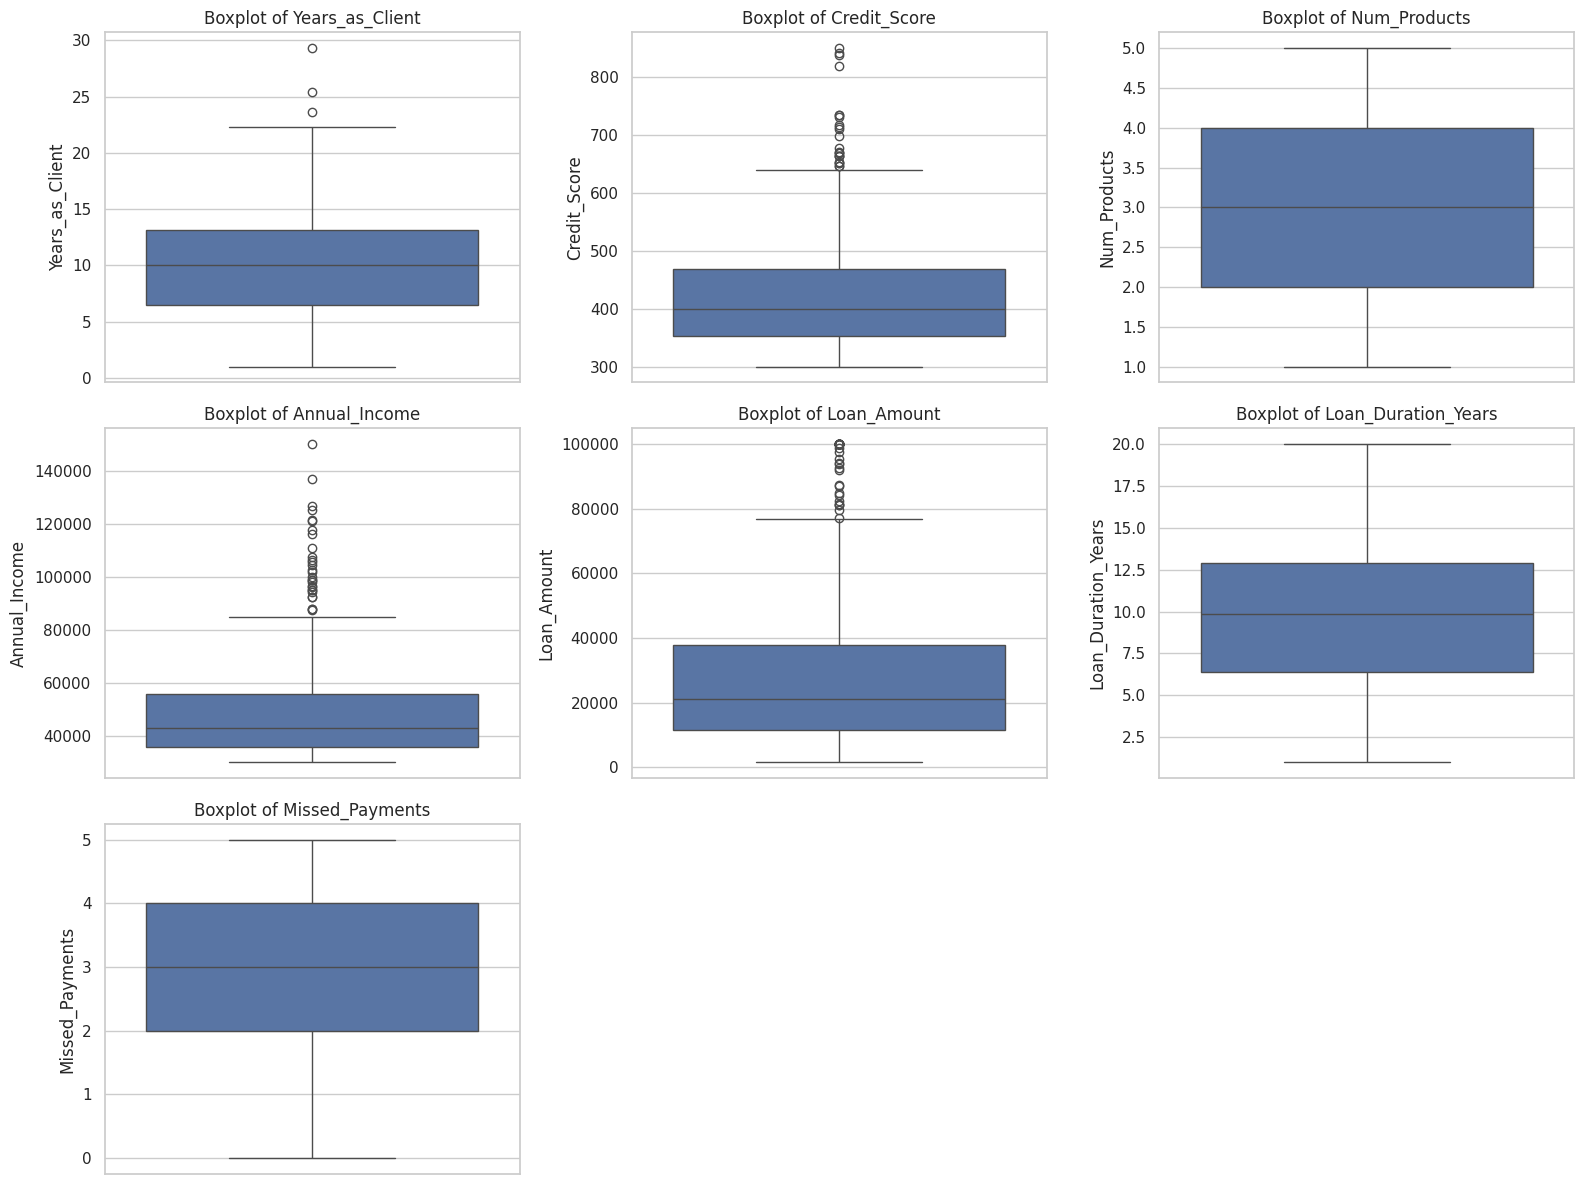

In [12]:

plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


Boxplots for annual income, and credit score show a right skewed distribution, which makes sense, not too many people have the highest salaries!

Now let's spot which variables are correlated and drop any we can so the logistic regression model works better:

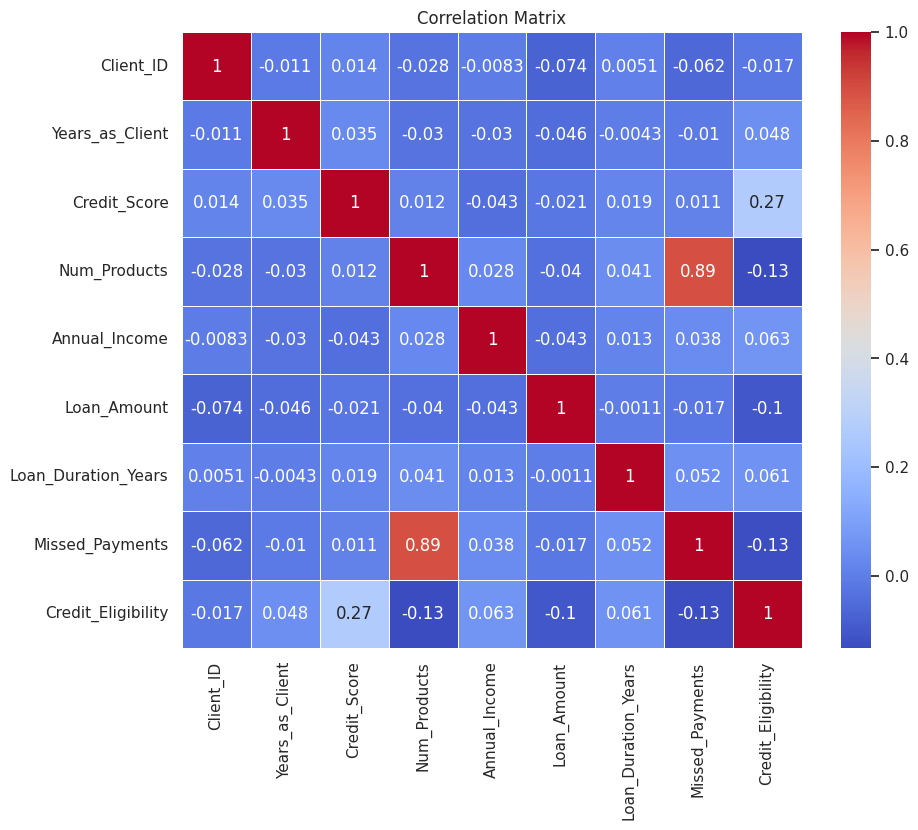

In [13]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

These matrices are just awesome. you can in the blink of an eye spot which variables are correlated, with these high contrast colors. 

Finally we can check how correlated variables are with the outcome variable, `credit_eligibility`:

In [14]:

print("\nCorrelation with Credit Eligibility:\n")
print(correlation_matrix['Credit_Eligibility'].sort_values(ascending=False))


Correlation with Credit Eligibility:

Credit_Eligibility     1.000000
Credit_Score           0.267139
Annual_Income          0.063101
Loan_Duration_Years    0.060990
Years_as_Client        0.048376
Client_ID             -0.016977
Loan_Amount           -0.102963
Missed_Payments       -0.125636
Num_Products          -0.132998
Name: Credit_Eligibility, dtype: float64


The most correlated variable is `credit_score`, which makes sense, as the credit score is a measure of how likely a person is to pay back a loan.

Since `num _of_products` and `missed_payments` are correlated, we can drop `num_of_products`:

In [15]:
# Drop the 'Num_Products' column from the dataset
df.drop(columns=['Num_Products'], inplace=True)

# Display the first few rows to verify the column has been dropped
print(df.head())

   Client_ID  Years_as_Client  Credit_Score  Annual_Income  Loan_Amount  \
0          1             12.5         476.0        48794.0       7801.0   
1          2              9.3         334.0        77529.0       4824.0   
2          3             13.2         434.0        44035.0       4383.0   
3          4             17.6         669.0        43693.0       6504.0   
4          5              8.8         308.0        31014.0      11636.0   

   Loan_Duration_Years  Missed_Payments  Credit_Eligibility  
0                  6.3              4.0                   0  
1                 19.5              1.0                   0  
2                 10.2              3.0                   0  
3                 13.8              5.0                   0  
4                  7.0              2.0                   0  


Once both dependent and independent variables has been assessed, we can go ahead and build the regression model.


## Training of the logistic regression model using cross validation 

Now that we have the data set ready, we can split it into training and testing sets, and train the logistic regression model using cross validation.


First we retrieve from the sci-kit learn library the necessary functions to split the data set, and train the model:

In [16]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve # for ROC curve, GINI
from scipy.stats import ks_2samp # For kolmogorov-smirnov test
import matplotlib.pyplot as plt

Now we can assign the independent variables to the variable `X`, and the dependent variable to the variable `y`: 

In [17]:
# X = features, y = target (Credit Eligibility)
X = df.drop(columns=['Credit_Eligibility', 'Client_ID']) # dropping these since they are not features
y = df['Credit_Eligibility']

Next, We can use the `train_test_split()` function to split the data set into training and testing sets, using 30% of the data as the test set:

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Now the `model` itself is created, using clas_weight='balanced' to account for the imbalanced nature of the data set: (not too many people are apt for a new credit line)

In [19]:
# Logistic Regression Model
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)

Once we have the model ready, we can pass it as an argument to the `cross_val_predict()` function, along with the independent and dependent variables, and the number of folds (5) for the cross validation:

In [20]:
# Cross-validation predictions
y_pred_prob_train = cross_val_predict(logreg, X_train, y_train, cv=5, method='predict_proba')[:, 1]  # Probabilities for class 1
y_pred_prob_test = logreg.fit(X_train, y_train).predict_proba(X_test)[:, 1]  # Test set probabilities

Now that the model has been trained we can evaluate its performance using the following metrics:

* KS statistic (Kolmogorov-Smirnov statistic)
* ROC curve, AUC score, and GINI coefficient
* PSI statistic (Population Stability Index)

First KS statistic:

In [21]:

# Get the KS statistic using the predicted probabilities from the test set
ks_stat, p_value = ks_2samp(y_pred_prob_test[y_test == 1], y_pred_prob_test[y_test == 0])
print(f'KS Statistic: {ks_stat}')

KS Statistic: 0.930635838150289


Now the GINI coefficient which comes from the area under the ROC curve:

In [22]:

# Calculate the AUC (Area Under the ROC Curve)
auc = roc_auc_score(y_test, y_pred_prob_test)
gini = 2 * auc - 1
print(f'AUC: {auc}')
print(f'GINI Coefficient: {gini}')


AUC: 0.9867877786952932
GINI Coefficient: 0.9735755573905864


And finally the PSI  (population stability index) statistic. This metric shows how big is the shift in the distribution of a variable, in this case the probability of being eligible for a new credit line, between the training and testing sets. I will help us to know if there is a significant change in the model's performance when it is applied to new data

To accomplish this we can define a custom function: `calculate psi()`

In [23]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10):
    """Calculate the PSI (Population Stability Index)"""
    def scale_range(input, min_val, max_val):
        input += -(np.min(input))
        input /= np.max(input) / (max_val - min_val)
        input += min_val
        return input
    
    breakpoints = np.arange(0, buckets + 1) / buckets * 100
    if buckettype == 'bins':
        bins = np.percentile(expected, breakpoints)
    elif buckettype == 'quantiles':
        bins = np.linspace(0, 1, num=buckets + 1)
    expected_percents = np.histogram(expected, bins=bins)[0] / len(expected)
    actual_percents = np.histogram(actual, bins=bins)[0] / len(actual)
    psi_value = np.sum((expected_percents - actual_percents) * np.log(expected_percents / actual_percents))
    return psi_value


And then use the new function to calculate the PSI statistic:

In [24]:

# Calculate PSI between training and test sets
psi_value = calculate_psi(y_pred_prob_train, y_pred_prob_test)
print(f'PSI: {psi_value}')


PSI: 0.05640157578800412


Now we can visualize the ROC curve, which showcases how the ratio of true positive to false negative predictions changes as the threshold for the model changes:

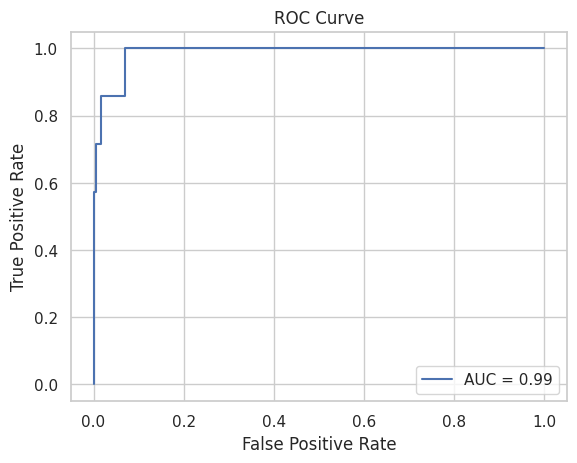

In [25]:

# ROC Curve plot
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_test)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Results

After training the Logistic Regression model, the following key metrics were obtained:

### **KS Statistic**: `0.988`

**The Kolmogorov-Smirnov (KS)** statistic measures the separation between the **cumulative distribution functions (CDF)** of the positive and negative classes in a binary classification. This statistic tells us How good the model separates the two groups.

* KS Statistic ranges from 0 to 1, with 1 representing perfect separation and 0 meaning no separation.
* A higher KS value indicates better model performance.

The KS statistic is the maximum difference betwen the CDFs of the two classes:

$$
KS = max | F_{positive}(x) - F_{negative} (x) |
$$

Literature suggests (Reference : [Credit Risk Analytics: Measurement Techniques, Applications, and Examples in SAS](https://www.wiley.com/en-us/Credit+Risk+Analytics%3A+Measurement+Techniques%2C+Applications%2C+and+Examples+in+SAS-p-9781119143987)) a KS Statistic of 0.4 or higher is generally good for credit scoring models, being 0.6 an excellent statistic. For this tailored dataset the statisitic is just as expected: as high as possible. 

### **AUC**: `0.993`

The Area under the Receiver Operator Characteristic Curve AUC for this model measures the model's ability to distinguish between positive (apt for credit) and negative (not apt) classes.

The process to print it is illustrated in the [Jupyter Notebook](./credit_elegibility_logreg.ipynb), but here we can also paste it here:

<img src="ROCcurve.png" alt="ROC curve" width="200" class="center"/>


AUC is calculated by plotting the True Positive Rate (sensitivity or recall) against the False Positive Rate (1-specificity) at different decision thresholds, and measuring the area under the resulting curve. 

We could say this metric is the probability that:

- A randomly chosen positive instance, is ranked higher by the model, than a randomly chosen negative instance.

the thresholds for this metric are stated as 0.8 < AUC < 0.9. (Reference: [Pattern Recognition and Machine Learning](https://link.springer.com/book/9780387310732)). 

 Having a dataset built to make sense, would allow you to expect such good performance for this metric. 

### **GINI Coefficient**: `0.986`

In a classification model, the Gini coefficient measures how well the model separates the positive (apt for credit) from the negative (not apt) class. This coefficient is closely related to the Area Under the Receiver Operating Characteristic Curve (AUC-ROC), they are related by the following equation

$$
Gini  = 2 * (AUC-1)
$$

* A Gini Coefficient of 1 represents perfect classification (the model perfectly distinguishes between classes).
* A Gini Coefficient of 0 suggests no discrimination power (random guessing).
* A Gini Coefficient below 0 indicates worse-than-random predictions.

Prior work (References: [Credit Scoring and Its Applications](https://epubs.siam.org/doi/book/10.1137/1.9781611974560), [Credit Risk Scorecards: Developing and Implementing Intelligent Credit Scoring](https://www.wiley.com/en-us/Credit+Risk+Scorecards%3A+Developing+and+Implementing+Intelligent+Credit+Scoring-p-9781119201731)) suggests  that a Gini coefficient grater than 0.5-0.6 is the ideal target for a classificantion model, keeping in mind 0.3- 0.5 can be accepted in early stages of model development. 

Again, Given the nature of the simulated dataset, The GINI coefficient accomplishes what was expected, a value close to 1 Which indigates good classification. 

### **PSI**: `0.184`

  PSI stands for Population Stability Index, which is used to compare two distributions:

  - The distribution of the outcome variable in the training set, in this case, whether or not the new credit line is approved for the training set observations
  - The distribution of that same variable in new data

This comparison is made by following these steps:

1. Binning the data sets: 
 The reference and test datasets are divided in to bins, of equal sizes. e.g. deciles

2. Calculating the proportion for each bin:
  The proportion of observations (In this specific case 1 = credit approved) in each bin, both for the reference dataset **$P_{ref}$** and the proportion of observations in the bin from the test dataset ****$P_{test}$**.

3. Measuring the sum of scaled differences between the proportions

Once the proportions of success in the test bin is calculated, it's difference from the training bin is calculated, and scaled as follows:

$$
PSI =  \sum \left( (P_{test}- P_{ref}) \cdot ln\left(\frac{P_{test}}{P_{ref}}     \right)         \right)
$$

Where : 
- **$P_{test}$** Is the proportion of observations in a bin from the test (new) dataset.

This way, we have a way to measure how the outcome variable changes between different populations, and assess whether or not the model is adequate, or if it should be re-trained. 

For this specific logistic regression model, with a PSI of 0.184, it is not needed to recalibrate the model yet, but there are minor population shifts. (reference: [Credit Risk Scorecards: Developing and Implementing Intelligent Credit Scoring](https://www.wiley.com/en-us/Credit+Risk+Scorecards%3A+Developing+and+Implementing+Intelligent+Credit+Scoring-p-9781119201731))
 
## Conclusion:

An automated continuously delivered process of training a machine learning logistic regression model is created and tested, with model metrics update being automated as well trough github actions. 

A synthetic dataset was simulated using python, having a sensible approach to the generation method of the response variable, using a set of logical conditions on client behaviour. The results of using this dataset motivate the use of real world data for the next project.

The distribution of the independent variables is assessed, as well multicollinearity detected using a correlation matrix.

The model demonstrates excellent performance across all key metrics, with strong discriminatory power (high KS, AUC, and GINI) and stable generalization (acceptable PSI). This indicates that the Logistic Regression model is highly effective in predicting credit eligibility.